Using device: cuda


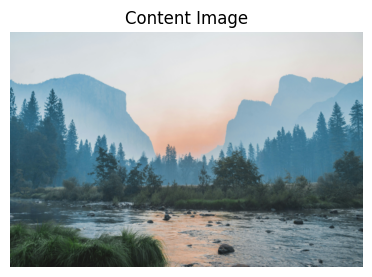

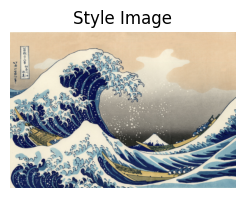

Epoch 0/1500, Total Loss: 779521753088.0
Epoch 100/1500, Total Loss: 186255982592.0
Epoch 200/1500, Total Loss: 53917655040.0
Epoch 300/1500, Total Loss: 33046700032.0
Epoch 400/1500, Total Loss: 24205754368.0
Epoch 500/1500, Total Loss: 19008897024.0
Epoch 600/1500, Total Loss: 15514429440.0
Epoch 700/1500, Total Loss: 12977258496.0
Epoch 800/1500, Total Loss: 11041222656.0
Epoch 900/1500, Total Loss: 9517148160.0
Learning rate scăzut la 0.0015 la epoch 1000
Epoch 1000/1500, Total Loss: 8282995200.0
Epoch 1100/1500, Total Loss: 7736059904.0
Epoch 1200/1500, Total Loss: 7229913088.0
Epoch 1300/1500, Total Loss: 6757237248.0
Epoch 1400/1500, Total Loss: 6314418688.0


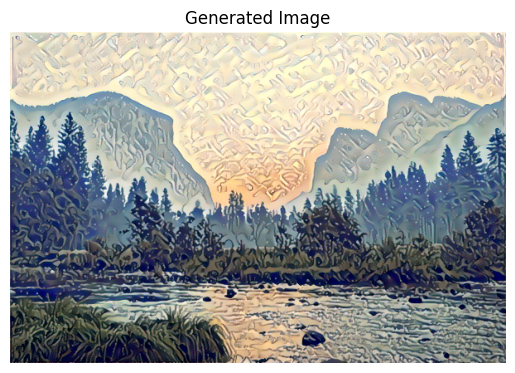

In [7]:
# Importăm librăriile necesare
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import os

# Setăm device-ul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Funcție pentru a încărca imaginile
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert('RGB')
    size = max(image.size) if max(image.size) <= max_size else max_size
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = in_transform(image).unsqueeze(0)
    return image.to(device)

# Funcție pentru a afișa imaginile corect (cu unnormalize)
def imshow(tensor, title=None):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225], device=image.device).view(3,1,1) + \
                 torch.tensor([0.485, 0.456, 0.406], device=image.device).view(3,1,1)
    image = torch.clamp(image, 0, 1)
    image = transforms.ToPILImage()(image.cpu())
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Calea imaginilor
content_img_path = "content2.jpg"
style_img_path = "style2.jpg"

# Încărcăm imaginile
content = load_image(content_img_path)
style = load_image(style_img_path)

# Afișăm imaginile
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imshow(content, title="Content Image")
plt.subplot(1,2,2)
imshow(style, title="Style Image")

# Încărcăm modelul VGG19
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Funcție pentru a extrage feature maps corect
def get_features(image, model, layers):
    features = {}
    x = image
    layer_mapping = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layer_mapping and layer_mapping[name] in layers:
            features[layer_mapping[name]] = x
    return features

# Alegem straturile folosite
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
all_layers = content_layers + style_layers

# Extragem feature maps fără gradient
with torch.no_grad():
    content_features = get_features(content, vgg, layers=all_layers)
    style_features = get_features(style, vgg, layers=all_layers)

# Calculăm Gram matrix-urile pentru stil
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

# Inițializăm imaginea generată
generated = content.clone().requires_grad_(True).to(device)

# Setăm hiperparametri
style_weight = 1e6
content_weight = 1e0

# Optimizer
optimizer = optim.Adam([generated], lr=0.003)

# 🏋️ Antrenare
# Setăm număr mare de epoci
epochs = 1500

# Optimizator
optimizer = optim.Adam([generated], lr=0.003)

# 🏋️ Antrenare avansată
for epoch in range(epochs):
    generated_features = get_features(generated, vgg, layers=all_layers)

    # Content loss
    content_loss = torch.mean((generated_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        generated_feature = generated_features[layer]
        generated_gram = gram_matrix(generated_feature)
        style_gram = style_grams[layer]
        layer_style_loss = torch.mean((generated_gram - style_gram)**2)
        style_loss += layer_style_loss / (generated_feature.shape[1]**2)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 🎯 Scădem learning rate-ul după 1000 epoci
    if epoch == 1000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0015
        print(f"Learning rate scăzut la 0.0015 la epoch {epoch}")

    # 📋 Print progres la fiecare 100 epoci
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}")

# 🖼️ Afișăm imaginea finală
imshow(generated, title="Generated Image")

# 💾 Salvăm imaginea
final_image = generated.clone().detach()
final_image = final_image.squeeze(0)
final_image = final_image * torch.tensor([0.229, 0.224, 0.225], device=final_image.device).view(3,1,1) + \
                           torch.tensor([0.485, 0.456, 0.406], device=final_image.device).view(3,1,1)
final_image = torch.clamp(final_image, 0, 1)
final_image = transforms.ToPILImage()(final_image.cpu())
final_image.save("generated_image_1500epochs.png")



In [6]:
from google.colab import files

uploaded = files.upload()


Saving style2.jpg to style2.jpg


In [2]:
import os

for file in os.listdir():
    print(file)


.config
sample_data
